In [9]:
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt


class Perceptron:
    
    def __init__(self, data, batch_size, input_size, output_size, optimizer, eta) -> None:
        (self.x_train, self.y_train), (self.x_test, self.y_test) = data
        self.batch_size = batch_size
        self.W = np.zeros((output_size, input_size))
        self.b = np.zeros((output_size, 1))
        self.input_size = input_size
        self.output_size = output_size
        self.m_dw, self.v_dw = 0, 0
        self.m_db, self.v_db = 0, 0
        self.eta = eta
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8
        self.optimizer = optimizer
        
    def softmax(self, z):
        exp_list = np.exp(z)
        return exp_list / sum(exp_list)

    def entropy_loss(self, pred, label):
        loss = -np.log(pred[int(label)])
        return loss

    def compute_batch_output(self, X):
        return np.array([np.matmul(self.W.transpose(), x) + self.b for x in X])
    
    def compute_SGD_batch_gradient(self, x_batch, y_batch):
        y_true = np.array([[1 if j == y_batch[i] else 0 for j in range(self.output_size)] for i in range(len(y_batch))])    # one-hot encoding for y-labels
        y_pred = np.array([self.softmax(np.dot(self.W, x_batch[i]) + np.squeeze(self.b)) for i in range(len(y_batch))])     # y = softmax(Wx + b)
        w_grad = (1/len(y_batch)) * np.dot(x_batch.transpose(), y_pred - y_true)                                            # compute batch gradient w.r.t. W
        b_grad = (1/len(y_batch)) * np.dot(np.ones((1,len(y_batch))), y_pred - y_true)                                      # compute batch gradient w.r.t. b
        return w_grad.transpose(), b_grad.transpose()
    
    def evaluate(self, X, Y):
        prediction_probs = np.array([self.softmax(np.dot(self.W, X[i]) + np.squeeze(self.b)) for i in range(len(Y))])
        Y_ = np.argmax(prediction_probs, axis=1)
        accuracy = sum(Y_ == Y) / float(len(Y))
        loss = np.mean([self.entropy_loss(prediction_probs[i], Y[i]) for i in range(len(Y))])
        return loss, accuracy
    
    def SGD_update(self, dW, db):
        self.W -= self.eta * dW
        self.b -= self.eta * db
    
    def Adam_update(self, t, dW, db):
        self.m_dW = self.beta1*self.m_dw + (1-self.beta1)*dW
        self.m_db = self.beta1*self.m_db + (1-self.beta1)*db
        self.v_dW = self.beta2*self.v_dw + (1-self.beta2)*(dW**2)
        self.v_db = self.beta2*self.v_db + (1-self.beta2)*(db**2)
        m_dW = self.m_dW / (1-self.beta1**t)
        m_db = self.m_db / (1-self.beta1**t)
        v_dW = self.v_dW / (1-self.beta2**t)
        v_db = self.v_db / (1-self.beta2**t)
        self.W -= self.eta * (m_dW / (np.sqrt(v_dW) + self.epsilon))
        self.b -= self.eta * (m_db / (np.sqrt(v_db) + self.epsilon))
    
    def optimize_parameters(self, iterations=100, early_stopping=True):
        train_loss_list, train_acc_list, test_loss_list, test_acc_list = [],[],[],[]
        iteration = 0
        best_test_loss = 10
        patience = 0
        for iteration in range(iterations):
            if early_stopping and patience > 5:
                print('Epoch %d/%d: Train Loss %.4f, Train Acc %.4f, Test Loss %.4f, Test Acc %.4f' % (iteration, iterations, train_loss, train_acc, test_loss, test_acc))
                break
            rand_indices = np.random.choice(self.x_train.shape[0], self.x_train.shape[0], replace=False) # shuffle data
            num_batch = self.x_train.shape[0] // self.batch_size
                
            for batch in range(num_batch):
                index = rand_indices[self.batch_size*batch:self.batch_size*(batch+1)]
                x_batch = self.x_train[index]
                y_batch = self.y_train[index]

                dW, db = self.compute_SGD_batch_gradient(x_batch, y_batch)
                if self.optimizer == "adam":
                    self.Adam_update(iteration+1, dW, db)
                else:
                    self.SGD_update(dW, db)

            train_loss, train_acc = self.evaluate(self.x_train, self.y_train)
            test_loss, test_acc = self.evaluate(self.x_test, self.y_test)
            train_loss_list.append(train_loss)
            train_acc_list.append(train_acc)
            test_loss_list.append(test_loss)
            test_acc_list.append(test_acc)
            
            if (iteration + 1) % (iterations//10) == 0:
                print('Epoch %d/%d: Train Loss %.4f, Train Acc %.4f, Test Loss %.4f, Test Acc %.4f' % (iteration+1, iterations, train_loss, train_acc, test_loss, test_acc))
            if round(test_loss_list[-1], 3) < best_test_loss:
                best_test_loss = round(test_loss_list[-1], 3)
                patience = 0
            else:
                patience += 1
            iteration += 1
        return train_loss_list, train_acc_list, test_loss_list, test_acc_list
    
    def plot_results(self, results):
        train_loss_list, train_acc_list, test_loss_list, test_acc_list = results
        plt.figure()
        plt.title("Accuracy Performance - {}".format(self.optimizer))
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.plot(range(len(test_acc_list)), test_acc_list, label="test_acc")
        plt.plot(range(len(train_acc_list)), train_acc_list, label="train_acc")
        plt.legend()
        plt.show()
        plt.clf()
        plt.figure()
        plt.title("Loss performance - {}".format(self.optimizer))
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.plot(range(len(test_loss_list)), test_loss_list, label="test_loss")
        plt.plot(range(len(train_loss_list)), train_loss_list, label="train_loss")
        plt.legend()
        plt.show()
        plt.clf()
        print("Convergence after {} iterations of training".format(len(train_loss_list)))
        print("Area under test loss curve:", np.sum(test_loss_list))
    

In [10]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

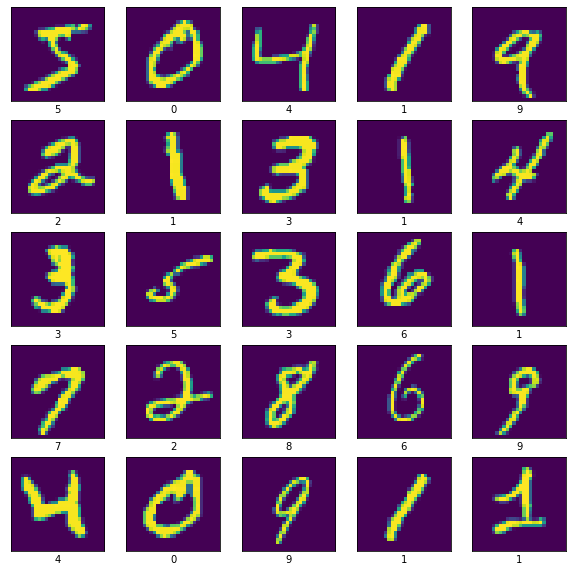

In [11]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(y_train[i])
plt.show()

In [12]:
x_train, x_test = (x_train / 255).reshape(len(x_train), -1), (x_test / 255).reshape(len(x_test), -1) # rescale pizel values: [0, 255] -> [0, 1.0]
data = (x_train, y_train), (x_test, y_test)

In [13]:
perceptron = Perceptron(data, batch_size=500, input_size=x_train.shape[-1], output_size=len(set(y_train)), optimizer="sgd", eta=0.1)
results = perceptron.optimize_parameters()

Epoch 10/100: Train Loss 0.3374, Train Acc 0.9066, Test Loss 0.3227, Test Acc 0.9121
Epoch 20/100: Train Loss 0.3074, Train Acc 0.9149, Test Loss 0.2974, Test Acc 0.9176
Epoch 30/100: Train Loss 0.2941, Train Acc 0.9184, Test Loss 0.2878, Test Acc 0.9192
Epoch 40/100: Train Loss 0.2854, Train Acc 0.9209, Test Loss 0.2813, Test Acc 0.9210
Epoch 50/100: Train Loss 0.2795, Train Acc 0.9226, Test Loss 0.2780, Test Acc 0.9225
Epoch 60/100: Train Loss 0.2756, Train Acc 0.9239, Test Loss 0.2763, Test Acc 0.9228
Epoch 68/100: Train Loss 0.2724, Train Acc 0.9246, Test Loss 0.2740, Test Acc 0.9223


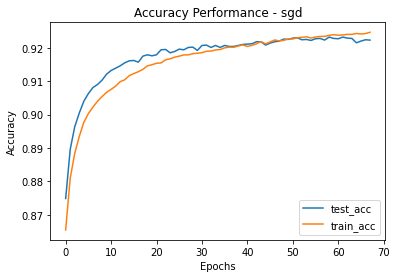

<Figure size 432x288 with 0 Axes>

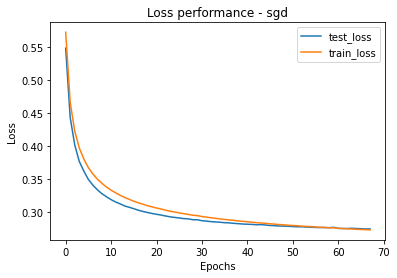

Convergence after 68 iterations of training
Area under test loss curve: 20.372390335047253


<Figure size 432x288 with 0 Axes>

In [14]:
perceptron.plot_results(results)

In [15]:
perceptron = Perceptron(data, batch_size=1000, input_size=x_train.shape[-1], output_size=len(set(y_train)), optimizer="adam", eta=0.001)
results = perceptron.optimize_parameters()

Epoch 10/100: Train Loss 0.3216, Train Acc 0.9116, Test Loss 0.3118, Test Acc 0.9139
Epoch 20/100: Train Loss 0.2889, Train Acc 0.9199, Test Loss 0.2857, Test Acc 0.9202
Epoch 30/100: Train Loss 0.2759, Train Acc 0.9242, Test Loss 0.2786, Test Acc 0.9237
Epoch 40/100: Train Loss 0.2706, Train Acc 0.9255, Test Loss 0.2773, Test Acc 0.9240
Epoch 43/100: Train Loss 0.2692, Train Acc 0.9267, Test Loss 0.2784, Test Acc 0.9244


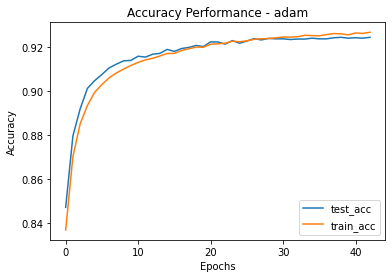

<Figure size 432x288 with 0 Axes>

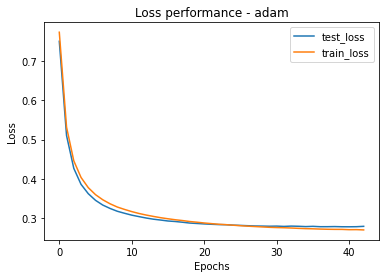

Convergence after 43 iterations of training
Area under test loss curve: 13.43695842378091


<Figure size 432x288 with 0 Axes>

In [16]:
perceptron.plot_results(results)